In [1]:
import numpy as np
import pandas as pd
import csv
import copy
from pprint import pprint
from math import *
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing

In [2]:
#Importing dataset
dataset = pd.read_csv('Train_E.csv')

#Handling missing values...
dataset = dataset.fillna(dataset.mean())

#Dropping date...
dataset = dataset.drop(['date'], axis = 1)

#One Hot Encoding for categorical columns (iso_code, continent, location)...
dummy_iso_code = pd.get_dummies(dataset['iso_code'], prefix = "iso_code")
dummy_continent = pd.get_dummies(dataset['continent'], prefix = "continent")
dummy_location = pd.get_dummies(dataset['location'], prefix = "location")
dataset = pd.concat([dummy_location, dataset], axis = 1)
dataset = pd.concat([dummy_continent, dataset], axis = 1)
dataset = pd.concat([dummy_iso_code, dataset], axis = 1)
dataset = dataset.drop(['iso_code', 'continent', 'location'], axis = 1)

In [3]:
#splits dataset into train, test in ratio 80:20 and does normalization on data
def train_test_split(s_dataset):
    features = s_dataset.columns
    k = int(len(s_dataset.index)*0.8)
    training_data = s_dataset.iloc[:k].reset_index(drop=True)
    testing_data = s_dataset.iloc[k:].reset_index(drop=True)
    scalar = preprocessing.StandardScaler()
    training_data = scalar.fit_transform(training_data)
    testing_data = scalar.transform(testing_data)
    return pd.DataFrame(data = training_data, columns = features), pd.DataFrame(data = testing_data, columns = features)

In [4]:
#random shuffle and splitting data into train, test
dataset = dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
training_data,testing_data = train_test_split(dataset)

In [5]:
#makes validation, train sets for k fold cross validation
def k_fold_validation(training_data,k):
    train_list = list()
    validation_list = list()
    l = len(training_data.index)
    fold = int(l/k)
    for i in range(k):
      validation_list.append(training_data.iloc[i*fold:(i+1)*int(l/k)].reset_index(drop = True))
      train_copy = copy.deepcopy(training_data)
      train_list.append(train_copy.drop(train_copy.index[i*fold:(i+1)*int(l/k)]).reset_index(drop = True))
    return train_list,validation_list

In [6]:
train_list,validation_list = k_fold_validation(training_data,5)

In [7]:
def summary_util(train_data):
    result = list()
    attributes = train_data.columns
    for attribute in attributes:
      if (attribute != 'life_expectancy'):
        result.append([train_data[attribute].mean(), train_data[attribute].std()])
    return result

def summary(train_data):
    l = len(train_data.index)
    result = {}
    classes = train_data['life_expectancy'].unique()
    freq = train_data['life_expectancy'].value_counts()
    prior_probs = {}
    for label in classes:
        prior_probs[label] = freq[label]/l;
        result[label] = summary_util(train_data[train_data['life_expectancy'] == label])
    return result,prior_probs

def gaussian(x, mean, stdev):
    if stdev == 0:
      return float(x == mean)
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent  

In [8]:
def probability(row,summ_by_class,freq):
  prob = 1.0
  i = 0
  for item in row.index:
    if(item != 'life_expectancy'):
      p=gaussian(row[item],summ_by_class[i][0],summ_by_class[i][1])
      if p==0:
        prob *=float(1.0/freq) #laplacian correction
      else:
        prob*=p
      i += 1      
  return prob

In [9]:
def test(train_data,test_data):
  sep_class,prior_probs=summary(train_data)
  predicted_class=[]
  freq = train_data['life_expectancy'].value_counts()
  for i,row in test_data.iterrows():
    prob_by_class={}   
    #print(row)
    for item in sep_class:      
      prob_by_class[item]=probability(row,sep_class[item],freq[item])*prior_probs[item]
    predicted_class.append(max(prob_by_class, key=prob_by_class.get))
  return predicted_class

In [10]:
def accuracy(train_data,test_data):
  predicted_classes = test(train_data,test_data)
  correct = 0
  for i in range(len(predicted_classes)):
    if predicted_classes[i] == test_data['life_expectancy'][i]:
      correct += 1
  return 100*correct/len(predicted_classes)

In [11]:
for i in range(5):
  print('validation-accuracy for set'+ str(i+1)+': '+str(accuracy(train_list[i],validation_list[i])))
print('test-accuracy: '+str(accuracy(train_list[0],testing_data))) # any of the 5 may be used as all give 100% accuracy on validation set.

validation-accuracy for set1: 100.0
validation-accuracy for set2: 100.0
validation-accuracy for set3: 100.0
validation-accuracy for set4: 100.0
validation-accuracy for set5: 100.0
test-accuracy: 100.0


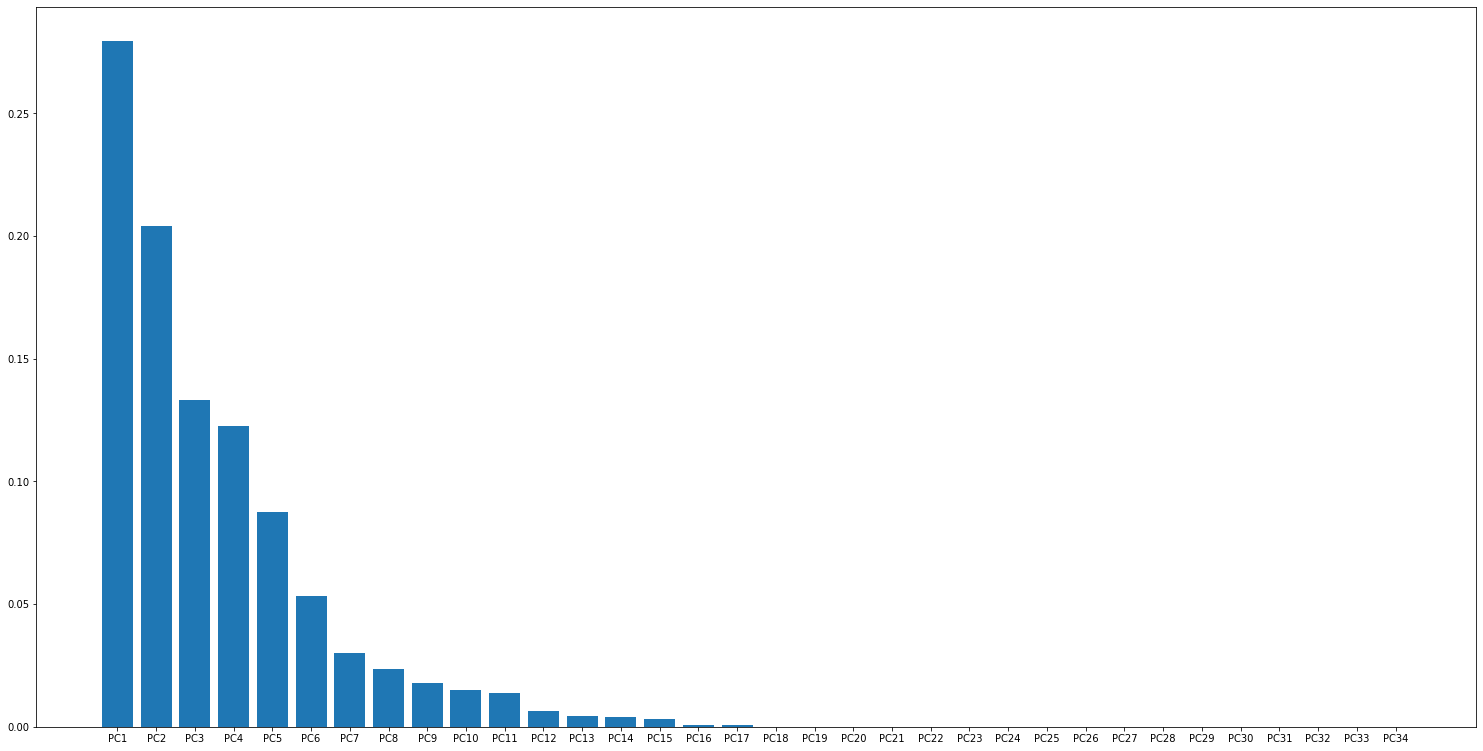

The number of components to be used is 9


In [12]:
#Applying PCA on processed data after normalization
dataset = dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
training_pca,testing_pca = train_test_split(dataset)

train_X = copy.deepcopy(training_pca)
train_X = train_X.drop(['life_expectancy'], axis = 1)
train_Y = copy.deepcopy(training_pca)
train_Y = train_Y['life_expectancy']
test_X = copy.deepcopy(testing_pca)
test_X = test_X.drop(['life_expectancy'], axis = 1)
test_Y = copy.deepcopy(testing_pca)
test_Y = test_Y['life_expectancy']

pc_columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17',
              'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34']

pca = decomposition.PCA()
pc = pca.fit_transform(train_X)

test_X = pca.transform(test_X)

pc_df_train = pd.DataFrame(data = pc, columns = pc_columns)
pc_df_train['life_expectancy'] = train_Y
pc_df_test = pd.DataFrame(data = test_X, columns = pc_columns)
pc_df_test['life_expectancy'] = test_Y

#print(pca.explained_variance_ratio_)

fig = plt.figure(figsize = (20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(pc_columns, pca.explained_variance_ratio_)
plt.show()

i = 0
var = 0
while (var<0.95):
  var += pca.explained_variance_ratio_[i]
  i += 1
print("The number of components to be used is " + str(i))



In [13]:
#Performing 5-fold cross validation on the new dataset obtained after performing PCA
pc_df_train = pc_df_train[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'life_expectancy']]
pc_df_test = pc_df_test[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'life_expectancy']]
pc_train_list,pc_validation_list = k_fold_validation(pc_df_train,5)
for i in range(5):
  print('pc_validation-accuracy for set'+ str(i+1)+': '+str(accuracy(pc_train_list[i],pc_validation_list[i])))
print('pc_test-accuracy: '+str(accuracy(pc_train_list[0],pc_df_test))) # 0,2,3,4 may be used as they give highest accuracy on validation data

pc_validation-accuracy for set1: 100.0
pc_validation-accuracy for set2: 98.93617021276596
pc_validation-accuracy for set3: 100.0
pc_validation-accuracy for set4: 100.0
pc_validation-accuracy for set5: 100.0
pc_test-accuracy: 100.0


In [14]:
#Removing Outliers in Dataset
training_data,testing_data = train_test_split(dataset) #splitting is done so as to normalize the data. (the procedure for normalization is included in train_test_split)
features = ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'stringency_index', 'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'diabetes_prevalence']
mean = []
stddev = []
for col in features:
  mean.append(pd.concat([training_data, testing_data])[col].mean())
  stddev.append(pd.concat([training_data, testing_data])[col].std())
new_train = pd.DataFrame(columns = training_data.columns)
for id in training_data.index:
  i = 0
  flag = 0
  for col in features:
    if (abs(training_data[col][id] - mean[i]) >3*stddev[i]):
      flag = flag + 1
    i = i + 1
  if (flag <= 2):
    new_train.loc[len(new_train)] = training_data.loc[id]

new_test = pd.DataFrame(columns = testing_data.columns)
for id in testing_data.index:
  i = 0
  flag = 0
  for col in features:
    if (abs(testing_data[col][id] - mean[i]) > 3*stddev[i]):
      flag = flag + 1
    i = i + 1
  if (flag <= 2):
    new_test.loc[len(new_test)] = testing_data.loc[id]


train_list,validation_list = k_fold_validation(new_train,5)
print('Number of samples removed from training data: ',len(training_data)-len(new_train))
print('Number of samples removed from training data: ',len(testing_data)-len(new_test))

Number of samples removed from training data:  43
Number of samples removed from training data:  12


In [15]:
#Performing Sequential Backward Selection Algorithm
j = 0
train_data = copy.deepcopy(train_list)
val_data = copy.deepcopy(validation_list)
while 1:
  j += 1  
  curr_acc = 0
  for i in range(5):
    curr_acc += accuracy(train_data[i],val_data[i])
  curr_acc /= 5
  print('Dropping feature no.'+str(j),end=' ')
  col_kick = None
  for column in train_data[0]:
    print('.',end = '')
    if column == 'life_expectancy':
      continue
    temp_acc = 0
    for i in range(5):
      temp_train = copy.deepcopy(train_data[i])
      temp_test = copy.deepcopy(val_data[i])
      temp_train = temp_train.drop([column],axis=1)
      temp_test = temp_test.drop([column],axis=1)
      temp_acc += accuracy(temp_train,temp_test)
    if temp_acc/5 >= curr_acc:
      curr_acc = temp_acc
      col_kick = column
  if col_kick != None:
    print("\nDropped: "+col_kick,end='\n\n')
    for i in range(5):
      train_data[i] = train_data[i].drop([col_kick],axis=1)
      val_data[i] = val_data[i].drop([col_kick],axis=1)
  else:
    break

Dropping feature no.1 ...................................
Dropped: iso_code_ABW

Dropping feature no.2 ..................................
Dropped: iso_code_AFG

Dropping feature no.3 .................................
Dropped: iso_code_AGO

Dropping feature no.4 ................................
Dropped: iso_code_ALB

Dropping feature no.5 ...............................
Dropped: iso_code_ARE

Dropping feature no.6 ..............................
Dropped: continent_Africa

Dropping feature no.7 .............................
Dropped: continent_Asia

Dropping feature no.8 ............................
Dropped: continent_Europe

Dropping feature no.9 ...........................
Dropped: continent_North America

Dropping feature no.10 ..........................
Dropped: location_Afghanistan

Dropping feature no.11 .........................
Dropped: location_Albania

Dropping feature no.12 ........................
Dropped: location_Angola

Dropping feature no.13 .......................
Dropped:

In [16]:
#Printing the features remaining 
print('Features remaining:',end=' ')
for column in train_data[0]:
    if column=='life_expectancy':
      continue
    print(column,end=' ')
    

Features remaining: diabetes_prevalence 

In [17]:
#Performing 5-fold cross validation on the new dataset obtained after performing Sequential Backward Selection Algorithm
dataset_SBS = copy.deepcopy(pd.concat([new_train, new_test]))
dataset_SBS = dataset_SBS[['diabetes_prevalence', 'life_expectancy']]
dataset_SBS = dataset_SBS.sample(frac = 1, random_state = 0).reset_index(drop = True)
sbs_training_data,sbs_testing_data = train_test_split(dataset_SBS)
sbs_train_list,sbs_validation_list = k_fold_validation(sbs_training_data,5)
for i in range(5):
  print('sbs_validation-accuracy for set'+ str(i+1)+': '+str(accuracy(sbs_train_list[i],sbs_validation_list[i])))
print('sbs_test-accuracy: '+str(accuracy(sbs_train_list[0],sbs_testing_data))) # any of the 5 may be used as all give 100% accuracy on validation set.

sbs_validation-accuracy for set1: 100.0
sbs_validation-accuracy for set2: 100.0
sbs_validation-accuracy for set3: 100.0
sbs_validation-accuracy for set4: 100.0
sbs_validation-accuracy for set5: 100.0
sbs_test-accuracy: 100.0
